In [2]:
## Standard libraries
import os
import json
import math
import numpy as np
import copy

## Imports for plotting
import matplotlib.pyplot as plt
from matplotlib import cm
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
import seaborn as sns
sns.set()

## Progress bar
from tqdm import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

C:\Users\nba055\AppData\Local\Temp\3\ipykernel_27268\984248910.py:13: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export


In [3]:
# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "D:/Nirwan/Ayush sir/data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "D:/Nirwan/Ayush sir/saved_models/tutorial4"

# Function for setting the seed
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available(): # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
set_seed(42)

# Additionally, some operations on a GPU are implemented stochastic for efficiency
# We want to ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [4]:
from torchvision.datasets import MNIST
from torchvision import transforms

# Transformations applied on each image => first make them a tensor, then normalize them with mean 0 and std 1
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.2861,), (0.3530,))
                               ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

# We define a set of data loaders that we can use for various purposes later.
# Note that for actually training a model, we will use different data loaders
# with a lower batch size.
train_loader = data.DataLoader(train_set, batch_size=1024, shuffle=True, drop_last=False)
val_loader = data.DataLoader(val_set, batch_size=1024, shuffle=False, drop_last=False)
test_loader = data.DataLoader(test_set, batch_size=1024, shuffle=False, drop_last=False)

In [5]:
print("Mean", (train_dataset.data.float() / 255.0).mean().item())
print("Std", (train_dataset.data.float() / 255.0).std().item())

Mean 0.13066047430038452
Std 0.30810782313346863


In [6]:
imgs, _ = next(iter(train_loader))
print(f"Mean: {imgs.mean().item():5.3f}")
print(f"Standard deviation: {imgs.std().item():5.3f}")
print(f"Maximum: {imgs.max().item():5.3f}")
print(f"Minimum: {imgs.min().item():5.3f}")

Mean: -0.442
Standard deviation: 0.871
Maximum: 2.022
Minimum: -0.810


In [7]:
class BaseNetwork(nn.Module):

    def __init__(self, act_fn, input_size=784, num_classes=10, hidden_sizes=[128, 256, 512, 1024, 512, 256, 128]):
        """
        Inputs:
            act_fn - Object of the activation function that should be used as non-linearity in the network.
            input_size - Size of the input images in pixels
            num_classes - Number of classes we want to predict
            hidden_sizes - A list of integers specifying the hidden layer sizes in the NN
        """
        super().__init__()

        # Create the network based on the specified hidden sizes
        layers = []
        layer_sizes = [input_size] + hidden_sizes
        for layer_index in range(1, len(layer_sizes)):
            layers += [nn.Linear(layer_sizes[layer_index-1], layer_sizes[layer_index]),
                       act_fn]
        layers += [nn.Linear(layer_sizes[-1], num_classes)]
        self.layers = nn.ModuleList(layers) # A module list registers a list of modules as submodules (e.g. for parameters)

        self.config = {"act_fn": act_fn.__class__.__name__, "input_size": input_size, "num_classes": num_classes, "hidden_sizes": hidden_sizes}

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.layers:
            x = l(x)
        return x

In [8]:
class Identity(nn.Module):
    def forward(self, x):
        return x

act_fn_by_name = {
    "tanh": nn.Tanh,
    "relu": nn.ReLU,
    "identity": Identity
}

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

In [10]:
##############################################################

def plot_dists(val_dict, color="C0", xlabel=None, stat="count", use_kde=True):
    columns = len(val_dict)
    fig, ax = plt.subplots(1, columns, figsize=(columns*3, 2.5))
    fig_index = 0
    for key in sorted(val_dict.keys()):
        key_ax = ax[fig_index%columns]
        sns.histplot(val_dict[key], ax=key_ax, color=color, bins=50, stat=stat,
                     kde=use_kde and ((val_dict[key].max()-val_dict[key].min())>1e-8)) # Only plot kde if there is variance
        key_ax.set_title(f"{key} " + (r"(%i $\to$ %i)" % (val_dict[key].shape[1], val_dict[key].shape[0]) if len(val_dict[key].shape)>1 else ""))
        if xlabel is not None:
            key_ax.set_xlabel(xlabel)
        fig_index += 1
    fig.subplots_adjust(wspace=0.4)
    return fig

##############################################################

def visualize_weight_distribution(model, color="C0"):
    weights = {}
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            continue
        key_name = f"Layer {name.split('.')[1]}"
        weights[key_name] = param.detach().view(-1).cpu().numpy()

    ## Plotting
    fig = plot_dists(weights, color=color, xlabel="Weight vals")
    fig.suptitle("Weight distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

##############################################################

def visualize_gradients(model, color="C0", print_variance=False):
    """
    Inputs:
        net - Object of class BaseNetwork
        color - Color in which we want to visualize the histogram (for easier separation of activation functions)
    """
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    model.zero_grad()
    preds = model(imgs)
    loss = F.cross_entropy(preds, labels) # Same as nn.CrossEntropyLoss, but as a function instead of module
    loss.backward()
    # We limit our visualization to the weight parameters and exclude the bias to reduce the number of plots
    grads = {name: params.grad.view(-1).cpu().clone().numpy() for name, params in model.named_parameters() if "weight" in name}
    model.zero_grad()

    ## Plotting
    fig = plot_dists(grads, color=color, xlabel="Grad magnitude")
    fig.suptitle("Gradient distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(grads.keys()):
            print(f"{key} - Variance: {np.var(grads[key])}")

##############################################################

def visualize_activations(model, color="C0", print_variance=False):
    model.eval()
    small_loader = data.DataLoader(train_set, batch_size=1024, shuffle=False)
    imgs, labels = next(iter(small_loader))
    imgs, labels = imgs.to(device), labels.to(device)

    # Pass one batch through the network, and calculate the gradients for the weights
    feats = imgs.view(imgs.shape[0], -1)
    activations = {}
    with torch.no_grad():
        for layer_index, layer in enumerate(model.layers):
            feats = layer(feats)
            if isinstance(layer, nn.Linear):
                activations[f"Layer {layer_index}"] = feats.view(-1).detach().cpu().numpy()

    ## Plotting
    fig = plot_dists(activations, color=color, stat="density", xlabel="Activation vals")
    fig.suptitle("Activation distribution", fontsize=14, y=1.05)
    plt.show()
    plt.close()

    if print_variance:
        for key in sorted(activations.keys()):
            print(f"{key} - Variance: {np.var(activations[key])}")


##############################################################

In [11]:
model = BaseNetwork(act_fn=Identity()).to(device)

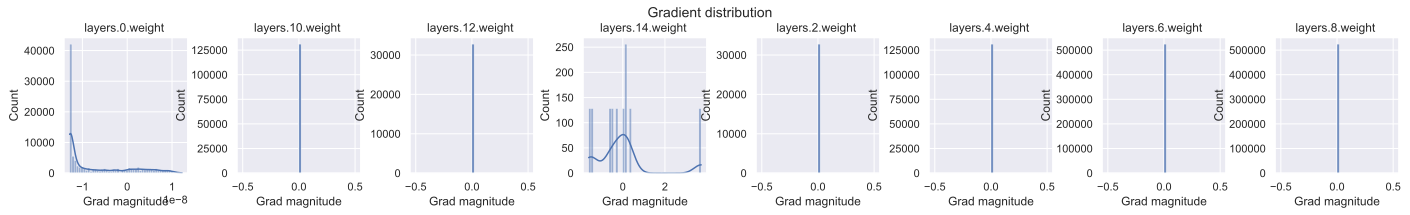

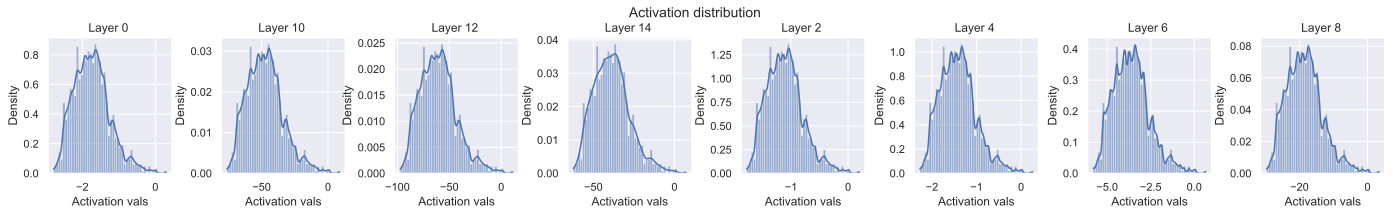

Layer 0 - Variance: 0.24378623068332672
Layer 10 - Variance: 184.19947814941406
Layer 12 - Variance: 301.79248046875
Layer 14 - Variance: 123.61419677734375
Layer 2 - Variance: 0.09985487163066864
Layer 4 - Variance: 0.16360226273536682
Layer 6 - Variance: 1.0721839666366577
Layer 8 - Variance: 28.10662078857422


In [12]:
def const_init(model, c=0.0):
    for name, param in model.named_parameters():
        param.data.fill_(c)

const_init(model, c=0.005)
visualize_gradients(model)
visualize_activations(model, print_variance=True)

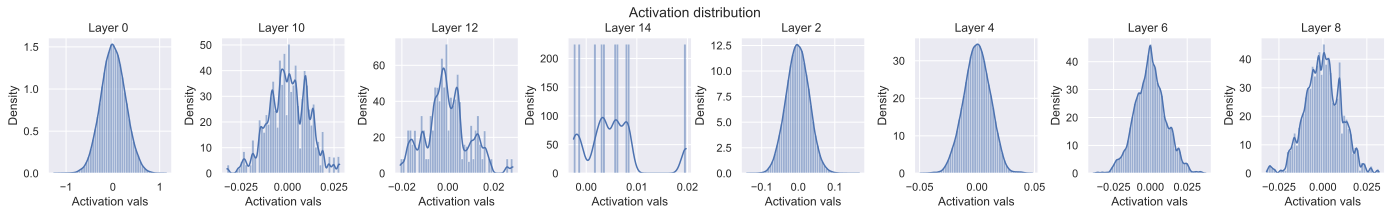

Layer 0 - Variance: 0.0686320960521698
Layer 10 - Variance: 0.00011201096640434116
Layer 12 - Variance: 9.0256922703702e-05
Layer 14 - Variance: 3.467509304755367e-05
Layer 2 - Variance: 0.0009738760418258607
Layer 4 - Variance: 0.00013145415869075805
Layer 6 - Variance: 0.0001101260058931075
Layer 8 - Variance: 0.0001020340496324934


In [13]:
def var_init(model, std=0.01):
    for name, param in model.named_parameters():
        param.data.normal_(std=std)

var_init(model, std=0.01)
visualize_activations(model, print_variance=True)

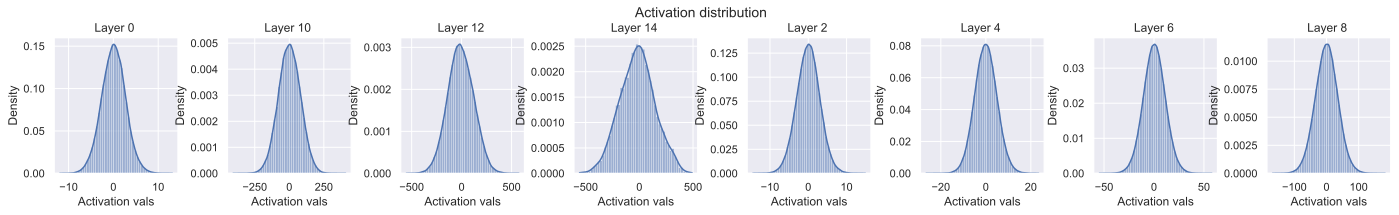

Layer 0 - Variance: 7.169447422027588
Layer 10 - Variance: 6327.5712890625
Layer 12 - Variance: 16622.31640625
Layer 14 - Variance: 26645.8125
Layer 2 - Variance: 9.124666213989258
Layer 4 - Variance: 24.240337371826172
Layer 6 - Variance: 120.91958618164062
Layer 8 - Variance: 1234.944580078125


In [14]:
var_init(model, std=0.1)
visualize_activations(model, print_variance=True)

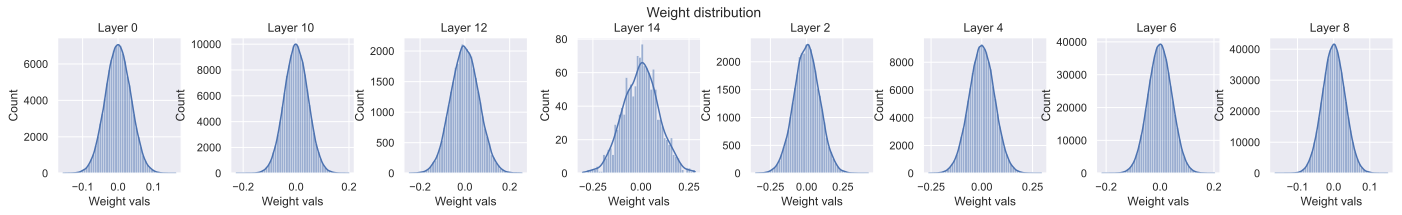

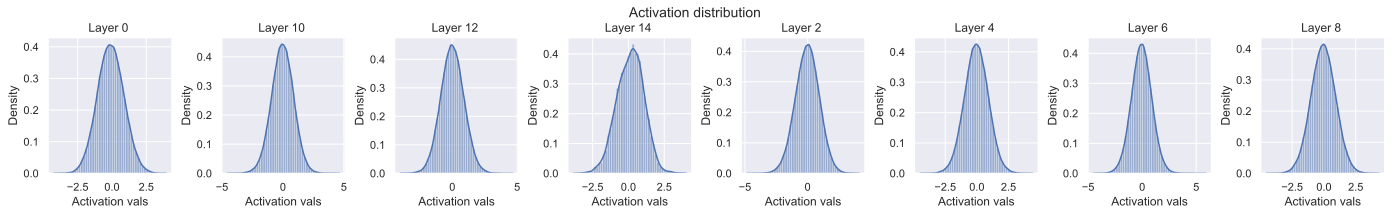

Layer 0 - Variance: 0.9266183376312256
Layer 10 - Variance: 0.8199190497398376
Layer 12 - Variance: 0.7974908351898193
Layer 14 - Variance: 0.8816136121749878
Layer 2 - Variance: 0.9010320901870728
Layer 4 - Variance: 0.8887530565261841
Layer 6 - Variance: 0.8901124000549316
Layer 8 - Variance: 0.9381453990936279


In [15]:
def equal_var_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            param.data.normal_(std=1.0/math.sqrt(param.shape[1]))

equal_var_init(model)
visualize_weight_distribution(model)
visualize_activations(model, print_variance=True)


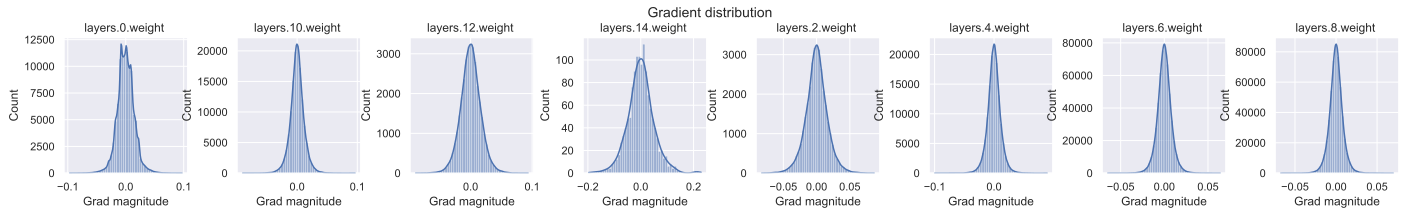

layers.0.weight - Variance: 0.00021424201258923858
layers.10.weight - Variance: 0.00013063814549241215
layers.12.weight - Variance: 0.0002603660395834595
layers.14.weight - Variance: 0.002467036945745349
layers.2.weight - Variance: 0.0002654146810527891
layers.4.weight - Variance: 0.00012101158063160256
layers.6.weight - Variance: 6.420815043384209e-05
layers.8.weight - Variance: 6.470338848885149e-05


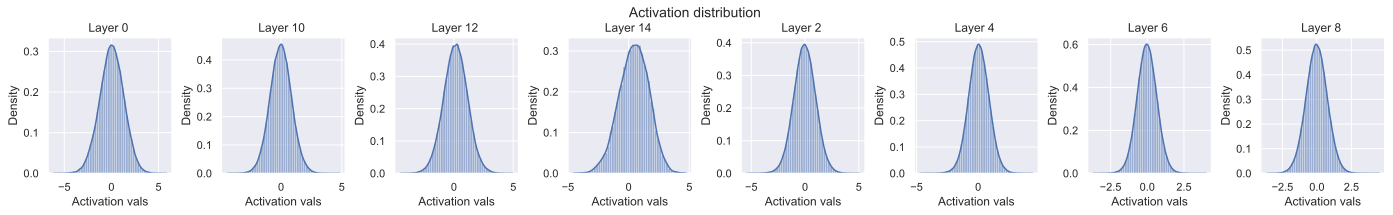

Layer 0 - Variance: 1.6204533576965332
Layer 10 - Variance: 0.7907505631446838
Layer 12 - Variance: 1.014424204826355
Layer 14 - Variance: 1.467373251914978
Layer 2 - Variance: 1.046284794807434
Layer 4 - Variance: 0.6854783296585083
Layer 6 - Variance: 0.4497389793395996
Layer 8 - Variance: 0.6000094413757324


In [16]:
def xavier_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        else:
            bound = math.sqrt(6)/math.sqrt(param.shape[0]+param.shape[1])
            param.data.uniform_(-bound, bound)

xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

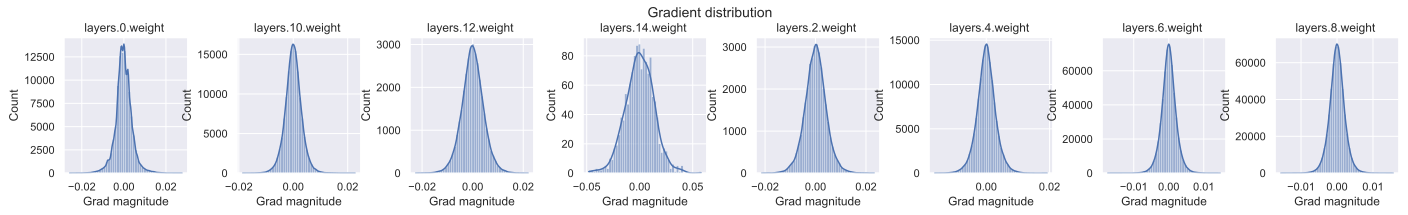

layers.0.weight - Variance: 1.5454779713763855e-05
layers.10.weight - Variance: 9.10749349714024e-06
layers.12.weight - Variance: 1.8353559426032007e-05
layers.14.weight - Variance: 0.00018151450785808265
layers.2.weight - Variance: 1.7814109014580026e-05
layers.4.weight - Variance: 8.867213182384148e-06
layers.6.weight - Variance: 4.429073669598438e-06
layers.8.weight - Variance: 4.613623332261341e-06


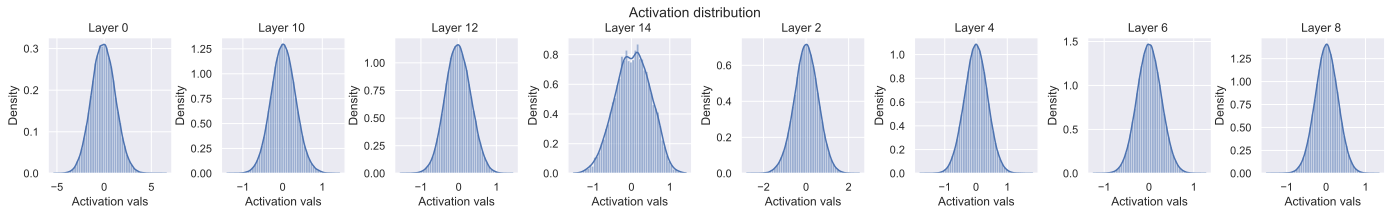

Layer 0 - Variance: 1.575738787651062
Layer 10 - Variance: 0.09574591368436813
Layer 12 - Variance: 0.11320539563894272
Layer 14 - Variance: 0.2048254907131195
Layer 2 - Variance: 0.32005584239959717
Layer 4 - Variance: 0.13566318154335022
Layer 6 - Variance: 0.07333841919898987
Layer 8 - Variance: 0.08191350847482681


In [17]:
model = BaseNetwork(act_fn=nn.Tanh()).to(device)
xavier_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

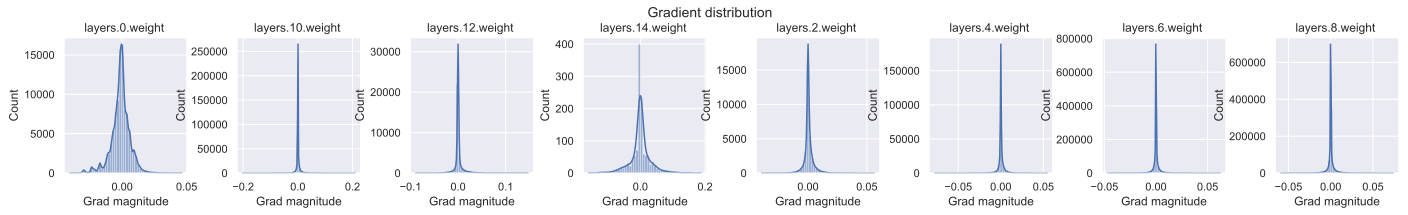

layers.0.weight - Variance: 5.2610346756409854e-05
layers.10.weight - Variance: 4.9063713959185407e-05
layers.12.weight - Variance: 9.728569420985878e-05
layers.14.weight - Variance: 0.0010588899021968246
layers.2.weight - Variance: 1.70894963957835e-05
layers.4.weight - Variance: 1.1726143384294119e-05
layers.6.weight - Variance: 8.049982170632575e-06
layers.8.weight - Variance: 1.9327326299389824e-05


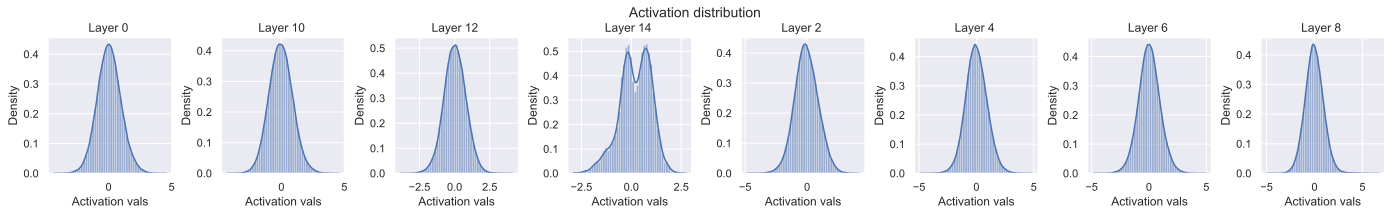

Layer 0 - Variance: 0.8881522417068481
Layer 10 - Variance: 0.8831956386566162
Layer 12 - Variance: 0.6115314960479736
Layer 14 - Variance: 0.6172560453414917
Layer 2 - Variance: 0.9130845665931702
Layer 4 - Variance: 0.8780830502510071
Layer 6 - Variance: 0.8842179179191589
Layer 8 - Variance: 0.9369329214096069


In [18]:
def kaiming_init(model):
    for name, param in model.named_parameters():
        if name.endswith(".bias"):
            param.data.fill_(0)
        elif name.startswith("layers.0"): # The first layer does not have ReLU applied on its input
            param.data.normal_(0, 1/math.sqrt(param.shape[1]))
        else:
            param.data.normal_(0, math.sqrt(2)/math.sqrt(param.shape[1]))

model = BaseNetwork(act_fn=nn.ReLU()).to(device)
kaiming_init(model)
visualize_gradients(model, print_variance=True)
visualize_activations(model, print_variance=True)

In [19]:
def _get_config_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".config")

def _get_model_file(model_path, model_name):
    return os.path.join(model_path, model_name + ".tar")

def _get_result_file(model_path, model_name):
    return os.path.join(model_path, model_name + "_results.json")

def load_model(model_path, model_name, net=None):
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    assert os.path.isfile(config_file), f"Could not find the config file \"{config_file}\". Are you sure this is the correct path and you have your model config stored here?"
    assert os.path.isfile(model_file), f"Could not find the model file \"{model_file}\". Are you sure this is the correct path and you have your model stored here?"
    with open(config_file, "r") as f:
        config_dict = json.load(f)
    if net is None:
        act_fn_name = config_dict["act_fn"].pop("name").lower()
        assert act_fn_name in act_fn_by_name, f"Unknown activation function \"{act_fn_name}\". Please add it to the \"act_fn_by_name\" dict."
        act_fn = act_fn_by_name[act_fn_name]()
        net = BaseNetwork(act_fn=act_fn, **config_dict)
    net.load_state_dict(torch.load(model_file))
    return net

def save_model(model, model_path, model_name):
    config_dict = model.config
    os.makedirs(model_path, exist_ok=True)
    config_file, model_file = _get_config_file(model_path, model_name), _get_model_file(model_path, model_name)
    with open(config_file, "w") as f:
        json.dump(config_dict, f)
    torch.save(model.state_dict(), model_file)

def train_model(net, model_name, optim_func, max_epochs=50, batch_size=256, overwrite=False):
    """
    Train a model on the training set of FashionMNIST

    Inputs:
        net - Object of BaseNetwork
        model_name - (str) Name of the model, used for creating the checkpoint names
        max_epochs - Number of epochs we want to (maximally) train for
        patience - If the performance on the validation set has not improved for #patience epochs, we stop training early
        batch_size - Size of batches used in training
        overwrite - Determines how to handle the case when there already exists a checkpoint. If True, it will be overwritten. Otherwise, we skip training.
    """
    file_exists = os.path.isfile(_get_model_file(CHECKPOINT_PATH, model_name))
    if file_exists and not overwrite:
        print(f"Model file of \"{model_name}\" already exists. Skipping training...")
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "r") as f:
            results = json.load(f)
    else:
        if file_exists:
            print("Model file exists, but will be overwritten...")

        # Defining optimizer, loss and data loader
        optimizer =  optim_func(net.parameters())
        loss_module = nn.CrossEntropyLoss()
        train_loader_local = data.DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True, pin_memory=True)

        results = None
        val_scores = []
        train_losses, train_scores = [], []
        best_val_epoch = -1
        for epoch in range(max_epochs):
            ############
            # Training #
            ############
            net.train()
            true_preds, count = 0., 0
            t = tqdm(train_loader_local, leave=False)
            for imgs, labels in t:
                imgs, labels = imgs.to(device), labels.to(device)
                optimizer.zero_grad()
                preds = net(imgs)
                loss = loss_module(preds, labels)
                loss.backward()
                optimizer.step()
                # Record statistics during training
                true_preds += (preds.argmax(dim=-1) == labels).sum().item()
                count += labels.shape[0]
                t.set_description(f"Epoch {epoch+1}: loss={loss.item():4.2f}")
                train_losses.append(loss.item())
            train_acc = true_preds / count
            train_scores.append(train_acc)

            ##############
            # Validation #
            ##############
            val_acc = test_model(net, val_loader)
            val_scores.append(val_acc)
            print(f"[Epoch {epoch+1:2d}] Training accuracy: {train_acc*100.0:05.2f}%, Validation accuracy: {val_acc*100.0:05.2f}%")

            if len(val_scores) == 1 or val_acc > val_scores[best_val_epoch]:
                print("\t   (New best performance, saving model...)")
                save_model(net, CHECKPOINT_PATH, model_name)
                best_val_epoch = epoch

    if results is None:
        load_model(CHECKPOINT_PATH, model_name, net=net)
        test_acc = test_model(net, test_loader)
        results = {"test_acc": test_acc, "val_scores": val_scores, "train_losses": train_losses, "train_scores": train_scores}
        with open(_get_result_file(CHECKPOINT_PATH, model_name), "w") as f:
            json.dump(results, f)

    # Plot a curve of the validation accuracy
    sns.set()
    plt.plot([i for i in range(1,len(results["train_scores"])+1)], results["train_scores"], label="Train")
    plt.plot([i for i in range(1,len(results["val_scores"])+1)], results["val_scores"], label="Val")
    plt.xlabel("Epochs")
    plt.ylabel("Validation accuracy")
    plt.ylim(min(results["val_scores"]), max(results["train_scores"])*1.01)
    plt.title(f"Validation performance of {model_name}")
    plt.legend()
    plt.show()
    plt.close()

    print((f" Test accuracy: {results['test_acc']*100.0:4.2f}% ").center(50, "=")+"\n")
    return results


def test_model(net, data_loader):
    """
    Test a model on a specified dataset.

    Inputs:
        net - Trained model of type BaseNetwork
        data_loader - DataLoader object of the dataset to test on (validation or test)
    """
    net.eval()
    true_preds, count = 0., 0
    for imgs, labels in data_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        with torch.no_grad():
            preds = net(imgs).argmax(dim=-1)
            true_preds += (preds == labels).sum().item()
            count += labels.shape[0]
    test_acc = true_preds / count
    return test_acc

In [20]:
class OptimizerTemplate:

    def __init__(self, params, lr):
        self.params = list(params)
        self.lr = lr

    def zero_grad(self):
        ## Set gradients of all parameters to zero
        for p in self.params:
            if p.grad is not None:
                p.grad.detach_() # For second-order optimizers important
                p.grad.zero_()

    @torch.no_grad()
    def step(self):
        ## Apply update step to all parameters
        for p in self.params:
            if p.grad is None: # We skip parameters without any gradients
                continue
            self.update_param(p)

    def update_param(self, p):
        # To be implemented in optimizer-specific classes
        raise NotImplementedError

In [21]:
class SGD(OptimizerTemplate):

    def __init__(self, params, lr):
        super().__init__(params, lr)

    def update_param(self, p):
        p_update = -self.lr * p.grad
        p.add_(p_update) # In-place update => saves memory and does not create computation graph

In [22]:
class SGDMomentum(OptimizerTemplate):

    def __init__(self, params, lr, momentum=0.0):
        super().__init__(params, lr)
        self.momentum = momentum # Corresponds to beta_1 in the equation above
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params} # Dict to store m_t

    def update_param(self, p):
        self.param_momentum[p] = (1 - self.momentum) * p.grad + self.momentum * self.param_momentum[p]
        p_update = -self.lr * self.param_momentum[p]
        p.add_(p_update)

In [23]:
class Adam(OptimizerTemplate):

    def __init__(self, params, lr, beta1=0.9, beta2=0.999, eps=1e-8):
        super().__init__(params, lr)
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.param_step = {p: 0 for p in self.params} # Remembers "t" for each parameter for bias correction
        self.param_momentum = {p: torch.zeros_like(p.data) for p in self.params}
        self.param_2nd_momentum = {p: torch.zeros_like(p.data) for p in self.params}

    def update_param(self, p):
        self.param_step[p] += 1

        self.param_momentum[p] = (1 - self.beta1) * p.grad + self.beta1 * self.param_momentum[p]
        self.param_2nd_momentum[p] = (1 - self.beta2) * (p.grad)**2 + self.beta2 * self.param_2nd_momentum[p]

        bias_correction_1 = 1 - self.beta1 ** self.param_step[p]
        bias_correction_2 = 1 - self.beta2 ** self.param_step[p]

        p_2nd_mom = self.param_2nd_momentum[p] / bias_correction_2
        p_mom = self.param_momentum[p] / bias_correction_1
        p_lr = self.lr / (torch.sqrt(p_2nd_mom) + self.eps)
        p_update = -p_lr * p_mom

        p.add_(p_update)

In [24]:
base_model = BaseNetwork(act_fn=nn.ReLU(), hidden_sizes=[512,256,256,128])
kaiming_init(base_model)

[Epoch  1] Training accuracy: 86.43%, Validation accuracy: 94.15%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 95.71%, Validation accuracy: 96.00%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 97.11%, Validation accuracy: 96.58%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 97.99%, Validation accuracy: 96.91%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 98.24%, Validation accuracy: 96.99%
	   (New best performance, saving model...)


[Epoch  6] Training accuracy: 98.92%, Validation accuracy: 97.04%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 99.25%, Validation accuracy: 96.97%


[Epoch  8] Training accuracy: 99.48%, Validation accuracy: 97.09%
	   (New best performance, saving model...)


[Epoch  9] Training accuracy: 99.30%, Validation accuracy: 97.30%
	   (New best performance, saving model...)


[Epoch 10] Training accuracy: 99.79%, Validation accuracy: 97.42%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 99.88%, Validation accuracy: 97.57%
	   (New best performance, saving model...)


[Epoch 12] Training accuracy: 99.92%, Validation accuracy: 97.60%
	   (New best performance, saving model...)


[Epoch 13] Training accuracy: 99.96%, Validation accuracy: 97.60%


[Epoch 14] Training accuracy: 99.97%, Validation accuracy: 97.53%


[Epoch 15] Training accuracy: 99.99%, Validation accuracy: 97.61%
	   (New best performance, saving model...)


[Epoch 16] Training accuracy: 100.00%, Validation accuracy: 97.58%


[Epoch 17] Training accuracy: 100.00%, Validation accuracy: 97.61%


[Epoch 18] Training accuracy: 100.00%, Validation accuracy: 97.55%


[Epoch 19] Training accuracy: 100.00%, Validation accuracy: 97.62%
	   (New best performance, saving model...)


[Epoch 20] Training accuracy: 100.00%, Validation accuracy: 97.62%


[Epoch 21] Training accuracy: 100.00%, Validation accuracy: 97.61%


[Epoch 22] Training accuracy: 100.00%, Validation accuracy: 97.66%
	   (New best performance, saving model...)


[Epoch 23] Training accuracy: 100.00%, Validation accuracy: 97.68%
	   (New best performance, saving model...)


[Epoch 24] Training accuracy: 100.00%, Validation accuracy: 97.62%


[Epoch 25] Training accuracy: 100.00%, Validation accuracy: 97.63%


[Epoch 26] Training accuracy: 100.00%, Validation accuracy: 97.62%


[Epoch 27] Training accuracy: 100.00%, Validation accuracy: 97.61%


[Epoch 28] Training accuracy: 100.00%, Validation accuracy: 97.62%


[Epoch 29] Training accuracy: 100.00%, Validation accuracy: 97.60%


[Epoch 30] Training accuracy: 100.00%, Validation accuracy: 97.65%


[Epoch 31] Training accuracy: 100.00%, Validation accuracy: 97.60%


[Epoch 32] Training accuracy: 100.00%, Validation accuracy: 97.65%


[Epoch 33] Training accuracy: 100.00%, Validation accuracy: 97.65%


[Epoch 34] Training accuracy: 100.00%, Validation accuracy: 97.66%


[Epoch 35] Training accuracy: 100.00%, Validation accuracy: 97.66%


[Epoch 36] Training accuracy: 100.00%, Validation accuracy: 97.65%


[Epoch 37] Training accuracy: 100.00%, Validation accuracy: 97.67%


[Epoch 38] Training accuracy: 100.00%, Validation accuracy: 97.63%


[Epoch 39] Training accuracy: 100.00%, Validation accuracy: 97.64%


[Epoch 40] Training accuracy: 100.00%, Validation accuracy: 97.61%


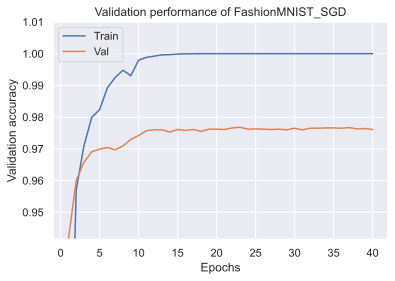

============= Test accuracy: 98.02% ==============



In [25]:
SGD_model = copy.deepcopy(base_model).to(device)
SGD_results = train_model(SGD_model, "FashionMNIST_SGD",
                          lambda params: SGD(params, lr=1e-1),
                          max_epochs=40, batch_size=256)

[Epoch  1] Training accuracy: 88.88%, Validation accuracy: 93.25%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 96.13%, Validation accuracy: 96.02%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 97.52%, Validation accuracy: 96.81%
	   (New best performance, saving model...)


[Epoch  4] Training accuracy: 98.09%, Validation accuracy: 96.43%


[Epoch  5] Training accuracy: 98.68%, Validation accuracy: 97.03%
	   (New best performance, saving model...)


[Epoch  6] Training accuracy: 99.01%, Validation accuracy: 96.96%


[Epoch  7] Training accuracy: 99.31%, Validation accuracy: 97.23%
	   (New best performance, saving model...)


[Epoch  8] Training accuracy: 99.51%, Validation accuracy: 97.25%
	   (New best performance, saving model...)


[Epoch  9] Training accuracy: 99.68%, Validation accuracy: 97.21%


[Epoch 10] Training accuracy: 99.83%, Validation accuracy: 97.33%
	   (New best performance, saving model...)


[Epoch 11] Training accuracy: 99.88%, Validation accuracy: 97.27%


[Epoch 12] Training accuracy: 99.94%, Validation accuracy: 97.53%
	   (New best performance, saving model...)


[Epoch 13] Training accuracy: 99.98%, Validation accuracy: 97.57%
	   (New best performance, saving model...)


[Epoch 14] Training accuracy: 99.98%, Validation accuracy: 97.58%
	   (New best performance, saving model...)


[Epoch 15] Training accuracy: 99.99%, Validation accuracy: 97.55%


[Epoch 16] Training accuracy: 100.00%, Validation accuracy: 97.52%


[Epoch 17] Training accuracy: 100.00%, Validation accuracy: 97.60%
	   (New best performance, saving model...)


[Epoch 18] Training accuracy: 100.00%, Validation accuracy: 97.53%


[Epoch 19] Training accuracy: 100.00%, Validation accuracy: 97.58%


[Epoch 20] Training accuracy: 100.00%, Validation accuracy: 97.50%


[Epoch 21] Training accuracy: 100.00%, Validation accuracy: 97.54%


[Epoch 22] Training accuracy: 100.00%, Validation accuracy: 97.56%


[Epoch 23] Training accuracy: 100.00%, Validation accuracy: 97.59%


[Epoch 24] Training accuracy: 100.00%, Validation accuracy: 97.57%


[Epoch 25] Training accuracy: 100.00%, Validation accuracy: 97.61%
	   (New best performance, saving model...)


[Epoch 26] Training accuracy: 100.00%, Validation accuracy: 97.59%


[Epoch 27] Training accuracy: 100.00%, Validation accuracy: 97.60%


[Epoch 28] Training accuracy: 100.00%, Validation accuracy: 97.59%


[Epoch 29] Training accuracy: 100.00%, Validation accuracy: 97.62%
	   (New best performance, saving model...)


[Epoch 30] Training accuracy: 100.00%, Validation accuracy: 97.59%


[Epoch 31] Training accuracy: 100.00%, Validation accuracy: 97.58%


[Epoch 32] Training accuracy: 100.00%, Validation accuracy: 97.58%


[Epoch 33] Training accuracy: 100.00%, Validation accuracy: 97.57%


[Epoch 34] Training accuracy: 100.00%, Validation accuracy: 97.58%


[Epoch 35] Training accuracy: 100.00%, Validation accuracy: 97.59%


[Epoch 36] Training accuracy: 100.00%, Validation accuracy: 97.58%


[Epoch 37] Training accuracy: 100.00%, Validation accuracy: 97.57%


[Epoch 38] Training accuracy: 100.00%, Validation accuracy: 97.55%


[Epoch 39] Training accuracy: 100.00%, Validation accuracy: 97.61%


[Epoch 40] Training accuracy: 100.00%, Validation accuracy: 97.60%


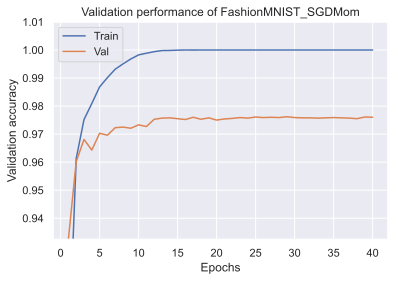

============= Test accuracy: 98.00% ==============



In [26]:
SGDMom_model = copy.deepcopy(base_model).to(device)
SGDMom_results = train_model(SGDMom_model, "FashionMNIST_SGDMom",
                             lambda params: SGDMomentum(params, lr=1e-1, momentum=0.9),
                             max_epochs=40, batch_size=256)

[Epoch  1] Training accuracy: 91.29%, Validation accuracy: 95.98%
	   (New best performance, saving model...)


[Epoch  2] Training accuracy: 96.93%, Validation accuracy: 96.43%
	   (New best performance, saving model...)


[Epoch  3] Training accuracy: 97.59%, Validation accuracy: 96.41%


[Epoch  4] Training accuracy: 98.03%, Validation accuracy: 96.64%
	   (New best performance, saving model...)


[Epoch  5] Training accuracy: 98.26%, Validation accuracy: 96.71%
	   (New best performance, saving model...)


[Epoch  6] Training accuracy: 98.64%, Validation accuracy: 96.97%
	   (New best performance, saving model...)


[Epoch  7] Training accuracy: 98.90%, Validation accuracy: 96.70%


[Epoch  8] Training accuracy: 98.92%, Validation accuracy: 97.42%
	   (New best performance, saving model...)


[Epoch  9] Training accuracy: 99.05%, Validation accuracy: 97.27%


[Epoch 10] Training accuracy: 99.17%, Validation accuracy: 97.33%


[Epoch 11] Training accuracy: 99.02%, Validation accuracy: 97.34%


[Epoch 12] Training accuracy: 99.31%, Validation accuracy: 97.36%


[Epoch 13] Training accuracy: 99.30%, Validation accuracy: 97.61%
	   (New best performance, saving model...)


[Epoch 14] Training accuracy: 99.38%, Validation accuracy: 97.45%


[Epoch 15] Training accuracy: 99.33%, Validation accuracy: 97.32%


[Epoch 16] Training accuracy: 99.48%, Validation accuracy: 97.32%


[Epoch 17] Training accuracy: 99.41%, Validation accuracy: 97.93%
	   (New best performance, saving model...)


[Epoch 18] Training accuracy: 99.38%, Validation accuracy: 97.44%


[Epoch 19] Training accuracy: 99.17%, Validation accuracy: 97.35%


[Epoch 20] Training accuracy: 99.48%, Validation accuracy: 97.65%


[Epoch 21] Training accuracy: 99.47%, Validation accuracy: 97.30%


[Epoch 22] Training accuracy: 99.54%, Validation accuracy: 97.40%


[Epoch 23] Training accuracy: 99.63%, Validation accuracy: 97.88%


[Epoch 24] Training accuracy: 99.69%, Validation accuracy: 97.39%


[Epoch 25] Training accuracy: 99.38%, Validation accuracy: 97.34%


[Epoch 26] Training accuracy: 99.53%, Validation accuracy: 97.71%


[Epoch 27] Training accuracy: 99.45%, Validation accuracy: 97.71%


[Epoch 28] Training accuracy: 99.60%, Validation accuracy: 97.76%


[Epoch 29] Training accuracy: 99.68%, Validation accuracy: 98.04%
	   (New best performance, saving model...)


[Epoch 30] Training accuracy: 99.78%, Validation accuracy: 97.85%


[Epoch 31] Training accuracy: 99.79%, Validation accuracy: 97.54%


[Epoch 32] Training accuracy: 99.54%, Validation accuracy: 97.42%


[Epoch 33] Training accuracy: 99.61%, Validation accuracy: 97.76%


[Epoch 34] Training accuracy: 99.71%, Validation accuracy: 97.54%


[Epoch 35] Training accuracy: 99.68%, Validation accuracy: 97.76%


[Epoch 36] Training accuracy: 99.58%, Validation accuracy: 97.91%


[Epoch 37] Training accuracy: 99.83%, Validation accuracy: 97.87%


[Epoch 38] Training accuracy: 99.72%, Validation accuracy: 97.35%


[Epoch 39] Training accuracy: 99.69%, Validation accuracy: 97.81%


[Epoch 40] Training accuracy: 99.70%, Validation accuracy: 97.73%


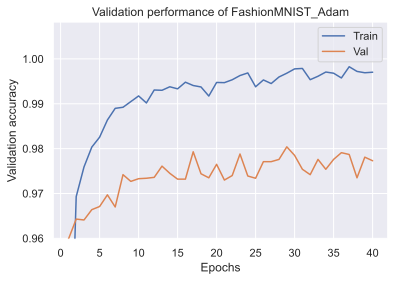

============= Test accuracy: 98.07% ==============



In [27]:
Adam_model = copy.deepcopy(base_model).to(device)
Adam_results = train_model(Adam_model, "FashionMNIST_Adam",
                           lambda params: Adam(params, lr=1e-3),
                           max_epochs=40, batch_size=256)

In [28]:
def pathological_curve_loss(w1, w2):
    # Example of a pathological curvature. There are many more possible, feel free to experiment here!
    x1_loss = torch.tanh(w1)**2 + 0.01 * torch.abs(w1)
    x2_loss = torch.sigmoid(w2)
    return x1_loss + x2_loss

C:\Users\nba055\AppData\Local\Temp\3\ipykernel_27268\4005370301.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d') if plot_3d else fig.gca()
c:\Users\nba055\.conda\envs\Nirwan_PyTorch\lib\site-packages\torch\functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:2228.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


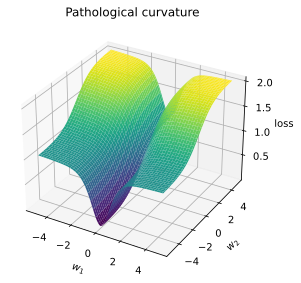

In [29]:
def plot_curve(curve_fn, x_range=(-5,5), y_range=(-5,5), plot_3d=False, cmap=cm.viridis, title="Pathological curvature"):
    fig = plt.figure()
    ax = fig.gca(projection='3d') if plot_3d else fig.gca()

    x = torch.arange(x_range[0], x_range[1], (x_range[1]-x_range[0])/100.)
    y = torch.arange(y_range[0], y_range[1], (y_range[1]-y_range[0])/100.)
    x, y = torch.meshgrid([x,y])
    z = curve_fn(x, y)
    x, y, z = x.numpy(), y.numpy(), z.numpy()

    if plot_3d:
        ax.plot_surface(x, y, z, cmap=cmap, linewidth=1, color="#000", antialiased=False)
        ax.set_zlabel("loss")
    else:
        ax.imshow(z.T[::-1], cmap=cmap, extent=(x_range[0], x_range[1], y_range[0], y_range[1]))
    plt.title(title)
    ax.set_xlabel(r"$w_1$")
    ax.set_ylabel(r"$w_2$")
    plt.tight_layout()
    return ax

sns.reset_orig()
_ = plot_curve(pathological_curve_loss, plot_3d=True)
plt.show()

In [30]:
def train_curve(optimizer_func, curve_func=pathological_curve_loss, num_updates=100, init=[5,5]):
    """
    Inputs:
        optimizer_func - Constructor of the optimizer to use. Should only take a parameter list
        curve_func - Loss function (e.g. pathological curvature)
        num_updates - Number of updates/steps to take when optimizing
        init - Initial values of parameters. Must be a list/tuple with two elements representing w_1 and w_2
    Outputs:
        Numpy array of shape [num_updates, 3] with [t,:2] being the parameter values at step t, and [t,2] the loss at t.
    """
    weights = nn.Parameter(torch.FloatTensor(init), requires_grad=True)
    optimizer = optimizer_func([weights])

    list_points = []
    for _ in range(num_updates):
        loss = curve_func(weights[0], weights[1])
        list_points.append(torch.cat([weights.data.detach(), loss.unsqueeze(dim=0).detach()], dim=0))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    points = torch.stack(list_points, dim=0).numpy()
    return points

In [31]:
SGD_points = train_curve(lambda params: SGD(params, lr=10))
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=10, momentum=0.9))
Adam_points = train_curve(lambda params: Adam(params, lr=1))

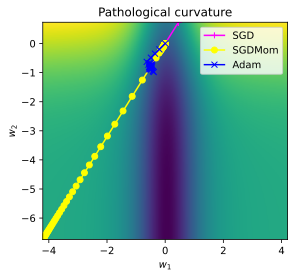

In [37]:
all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(pathological_curve_loss,
                x_range=(-np.absolute(all_points[:,0]).max(), np.absolute(all_points[:,0]).max()),
                y_range=(all_points[:,1].min(), all_points[:,1].max()),
                plot_3d=False)
ax.plot(SGD_points[:,0], SGD_points[:,1], color="magenta", marker="+", zorder=1, label="SGD")
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="yellow", marker="o", zorder=2, label="SGDMom")
ax.plot(Adam_points[:,0], Adam_points[:,1], color="blue", marker="x", zorder=3, label="Adam")
plt.legend()
plt.show()

C:\Users\nba055\AppData\Local\Temp\3\ipykernel_27268\4005370301.py:3: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d') if plot_3d else fig.gca()


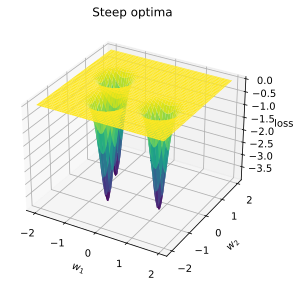

In [33]:
def bivar_gaussian(w1, w2, x_mean=0.0, y_mean=0.0, x_sig=1.0, y_sig=1.0):
    norm = 1 / (2 * np.pi * x_sig * y_sig)
    x_exp = (-1 * (w1 - x_mean)**2) / (2 * x_sig**2)
    y_exp = (-1 * (w2 - y_mean)**2) / (2 * y_sig**2)
    return norm * torch.exp(x_exp + y_exp)

def comb_func(w1, w2):
    z = -bivar_gaussian(w1, w2, x_mean=1.0, y_mean=-0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-1.0, y_mean=0.5, x_sig=0.2, y_sig=0.2)
    z -= bivar_gaussian(w1, w2, x_mean=-0.5, y_mean=-0.8, x_sig=0.2, y_sig=0.2)
    return z

_ = plot_curve(comb_func, x_range=(-2,2), y_range=(-2,2), plot_3d=True, title="Steep optima")

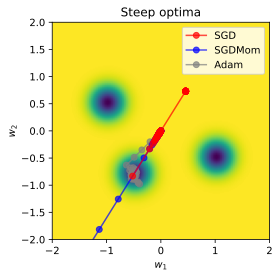

In [34]:
SGD_points = train_curve(lambda params: SGD(params, lr=.5), comb_func, init=[0,0])
SGDMom_points = train_curve(lambda params: SGDMomentum(params, lr=1, momentum=0.9), comb_func, init=[0,0])
Adam_points = train_curve(lambda params: Adam(params, lr=0.2), comb_func, init=[0,0])

all_points = np.concatenate([SGD_points, SGDMom_points, Adam_points], axis=0)
ax = plot_curve(comb_func,
                x_range=(-2, 2),
                y_range=(-2, 2),
                plot_3d=False,
                title="Steep optima")
ax.plot(SGD_points[:,0], SGD_points[:,1], color="red", marker="o", zorder=3, label="SGD", alpha=0.7)
ax.plot(SGDMom_points[:,0], SGDMom_points[:,1], color="blue", marker="o", zorder=2, label="SGDMom", alpha=0.7)
ax.plot(Adam_points[:,0], Adam_points[:,1], color="grey", marker="o", zorder=1, label="Adam", alpha=0.7)
ax.set_xlim(-2, 2)
ax.set_ylim(-2, 2)
plt.legend()
plt.show()